In [1]:
# Fill in your name using the format below and student ID number
your_name = "Kitsanelis, Christos"
student_id = "1489127"

In [2]:
# Before submission, set this to True so that you can render and verify this notebook without training deep learning models.
# Any deep learning models will be trained from file instead.
stop_training = True

In [3]:
# Uncomment the following line to run in Google Colab
# !pip install --quiet openml 

In [4]:
# Uncomment the following line to run in Google Colab
#%tensorflow_version 2.x
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU') # Check whether GPUs are available

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
%matplotlib inline
import openml as oml
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [6]:
from packaging import version
import sklearn
import tensorflow
sklearn_version = sklearn.__version__
tensorflow_version = tensorflow.__version__
if version.parse(sklearn_version) < version.parse("0.22.0"):
    print("scikit-learn is outdated. Please update now!")
if version.parse(tensorflow_version) < version.parse("2.1.0"):
    print("Tensorflow is outdated. This is version {}. Please update to 2.1.".format(tensorflow_version))
else:
    print("Hi{}, Looks good. You may continue :)".format(your_name.split(",")[1]))

Hi Christos, Looks good. You may continue :)


# Assignment 3

### Choice of libraries
We recommend to use Tensorflow in this assignment since that is what we covered in the labs. If you feel confident using PyTorch (and Skorch for the scikit-learn wrapper), that is allowed too, as long as you are able to implement the requested functions and return the requested data. Read the assignment carefully and ensure that you can. Note that you may also need to do a bit more work to implement certain helper functions and wrappers.

### Storing and submitting files
You must be able to store your models and submit them to GitHub Classroom. The evaluation functions used in this notebook will automatically store models for you.

If you want to run and solve the notebook on your local machine/laptop, fill in the path 'base_dir' to your assignment folder into the next cell.

If you use Colab, we recommend that you link it to your Google Drive:  
* Upload the assignment folder to your Google Drive (+ New > Folder Upload)
* Open Colab in a browser, open the 'Files' menu in the left sidebar, and click 'Mount Drive'
  * At this point you may need to authenticate
* Fill in the path to your assignment folder below
  * It's likely '/content/drive/My Drive/assignment-3-yourname'

In [7]:
#base_dir = '/content/drive/My Drive/TestAssignment' # For Google Colab
base_dir = './models/'

In [8]:
#Uncomment to link Colab notebook to Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

### Using GPUs
While you can solve this assignment on a CPU, using a GPU will speed things up training quite a bit. If you have a local GPU, you can use that. If you don't, we recommend Google Colab. When you are in Colab:
* In Runtime > Change runtime type, select the GPU under Hardware Accelerator
* Run the 3rd cell on the top of this notebook to check that the GPU is found.

Note that Colab may not always have GPUs ready all the time, and may deny you a GPU when you have used them a lot. When you are temporarily 'locked out', you can switch to a non-GPU runtime or to a local instance of Jupyter running on your machine.

### Constraints
* Your stored models should not be larger than 100MB when stored in file. GitHub will not allow uploading if they are.
* When questions ask you to provide an explanation, it should be less than 500
characters long. Some questions have a higher limit. Always answer in full sentences.
* Don't train for more than 100 epochs, i.e. don't throw excessing computational resources at the problem. If your model hasn't converged by then, think of ways it could be made to converge faster. In this assignment you are not after the last tiny improvement, you can stop when learning curves flatten out. Do at least 5 epochs to get a reasonable learning curve.

### Grading
Grading is based on the following aspects:
* Correctness in answering the question. Carefully read the question and answer
what is asked for. Train your models on the correct data. It should be clear on which data should be trained, but ask when in doubt. When something is not defined (e.g. the number of epochs or batch size), you can freely choose them.
* Clarity of your explanations. Write short but precise descriptions of what you did and why. Give short but clear explanations of the observed performance. 
After your explanation, your approach and model should make perfect sense. Refrain from using symbols as substitute for words in your explanation (e.g. no: "More layers -> more parameters" yes: "More layers mean more parameters"). 
* Part of your grade depends on how well your model performs. When the question says 'you should at least get x%', x% will give you a good but not the maximal grade. You can get the full grade when you are close to what is the expected maximal performance. You don't need to invest lots of effort into the last tiny improvement, though. Unless specified, we look at the accuracy on the validation set. If your learning curves are very erratic we'll compute a score based on the smoothed curves (i.e. single peaks don't count).
* The weight of each question is indicated. Take this into account when planning your time.

### Other tips
* Don't wait until the last minute to do the assignment. The models take time to train, most questions will require some thinking, and some require you to read up on some new concepts.
* Take care that you upload the results as requested. You need to submit not only the notebooks but also the trained models and learning curves (training histories). Be sure to run the verification script and check that all the results are included.
* We provide an evaluation function that also stored models to disk. After you are done training the model, set the 'train' attribute to False so that the model doesn't train again (and loads from file instead) when you restart and rerun your notebook.
* Explore. For many questions we'll ask you to explain your model design decisions. You cannot magically know the best solutions but you can experiment
based on your understanding and make decisions based on both your knowledge and experiments. Your explanation is at least as important as the performance of your model.
* Be original. We will check for plagiarism between student submissions.

### Data
The [Street View House Numbers Dataset](https://www.openml.org/d/41081) contains 32-by-32 RGB images centered around a single digit of a house number appearing in Google Street View. Many of the images do contain some distractors at the sides. It consists of 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10. Your goal is to build models that recognize the correct digit.

If you use Colab, uncomment the following to cache the dataset inside the VM. This will make reloading faster if you need to restart your notebook. After longer periods of inactivity, your VM may be recycled and the cache lost, in which case the dataset will be downloaded again. Also note that this dataset is about 1Gb large, and will take even more space in memory. You may need to switch to a high-RAM environment (Colab will ask you if you hit the limit).

In [9]:
# Use OpenML caching in Colab
# On your local machine, it will store data in a hidden folder '~/.openml'
#import os
#oml.config.cache_directory = os.path.expanduser('/content/cache')

In [8]:
# Download Streetview data. Takes a while (several minutes), and quite a bit of
# memory when it needs to download. After caching it loads faster.
SVHN = oml.datasets.get_dataset(41081)
X, y, _, _ = SVHN.get_data(dataset_format='array',
    target=SVHN.default_target_attribute)

Reshape, sample and split the data

In [9]:
from tensorflow.keras.utils import to_categorical

Xr = X.reshape((len(X),32,32,3))
Xr = Xr / 255.
yr = to_categorical(y)

In [10]:
# DO NOT EDIT. DO NOT OVERWRITE THESE VARIABLES.
from sklearn.model_selection import train_test_split
# We do an 80-20 split for the training and test set, and then again a 80-20 split into training and validation data
X_train_all, X_test, y_train_all, y_test = train_test_split(Xr,yr, stratify=yr, train_size=0.8, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_all,y_train_all, stratify=y_train_all, train_size=0.8, random_state=1)
evaluation_split = X_train, X_val, y_train, y_val

Check the formatting - and what the data looks like

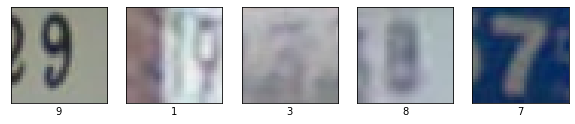

In [11]:
from random import randint

# Takes a list of row ids, and plots the corresponding images
# Use grayscale=True for plotting grayscale images
def plot_images(X, y, grayscale=False):
    fig, axes = plt.subplots(1, len(X),  figsize=(10, 5))
    for n in range(len(X)):
        if grayscale:
            axes[n].imshow(X[n], cmap='gray')
        else:
            axes[n].imshow(X[n])
        axes[n].set_xlabel((np.argmax(y[n])+1)%10) # Label is index+1
        axes[n].set_xticks(()), axes[n].set_yticks(())
    plt.show();

images = [randint(0,len(X_train)) for i in range(5)]
X_random = [X_train[i] for i in images]
y_random = [y_train[i] for i in images]
plot_images(X_random, y_random)

### Evaluation harness
We provide an evaluation function 'run_evaluation' that you should use to 
evaluate all your models. It also stores the trained models to disk so that
your submission can be quickly verified, as well as to avoid having to train
them over and over again. Your last run of the evaluation function (the last one
stored to file), is the one that will be evaluated. The 'train' argument indicates whether to train or to load from disk. We have provided helper functions for saving and loading models to/from file, assuming you use TensorFlow. If you use PyTorch you'll have to adapt them.

In [12]:
import os
import pickle
import pandas as pd
import numpy as np
# from tensorflow.keras.models import load_model # for use with tensorflow
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers 

custom_nadam = optimizers.Nadam(learning_rate=0.0005)

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')

def load_model_from_file(base_dir, name, extension='.h5'):
    """ Loads a model from a file. The returned model must have a 'fit' and 'summary'
    function following the Keras API. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
    base_dir -- Directory where the models are stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    try:
        model = models.load_model(os.path.join(base_dir, name+extension))
    except OSError:
        shout("Saved model could not be found. Was it trained and stored correctly? Is the base_dir correct?")
        return False
    return model

def save_model_to_file(model, base_dir, name, extension='.h5'):
    """ Saves a model to file. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
    model -- the model to be saved
    base_dir -- Directory where the models should be stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    model.save(os.path.join(base_dir, name+extension))

# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

# DO NOT EDIT
def run_evaluation(name, model_builder, data, base_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Training the model", verbose)
        if generator:
            generator, X_val, y_val = data
            history = model.fit(generator, epochs=epochs, batch_size=batch_size,
                              steps_per_epoch=steps_per_epoch, verbose=1, 
                              validation_data=(X_val, y_val))
            learning_curves = history.history
        else:
            X_train, X_val, y_train, y_val = data
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              verbose=1, validation_data=(X_val, y_val))
            learning_curves = history.history
        shout("Saving to file", verbose)
        save_model_to_file(model, base_dir, name)
        with open(os.path.join(base_dir, name+'.p'), 'wb') as file_pi:
            pickle.dump(learning_curves, file_pi)
        shout("Model stored in "+base_dir, verbose)
    else: # Load from file
        shout("Loading model from file", verbose)
        model = load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
        shout("Success!", verbose)
    # Report
    print(model.summary())
    lc = pd.DataFrame(learning_curves)
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    print(lc.apply(minMax))

## Part 1. Dense networks (10 points)

### Question 1.1: Baseline model (4 points)
- Build a dense network (with only dense layers) of at least 3 layers that is shaped like a pyramid: The first layer must have many nodes, and every subsequent layer must have increasingly fewer nodes, e.g. half as many. Implement a function 'build_model_1_1' that returns this model.
- You can explore different settings, but don't use any preprocessing or regularization yet. You should be able to achieve at least 70% accuracy, but more is of course better. Unless otherwise stated, you can use accuracy as the evaluation metric in all questions.
* Add a small description of your design choices (max. 500 characters) in 'answer_q_1_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- The name of the model should be 'model_1_1'. Evaluate it using the 'run_evaluation' function. For this question, you should not use more than 50 epochs.

Training the model
Train on 63544 samples, validate on 15887 samples
Epoch 1/50
63544/63544 [==============================] - 8s 132us/sample - loss: 2.0794 - accuracy: 0.2478 - val_loss: 1.6129 - val_accuracy: 0.4511
Epoch 2/50
63544/63544 [==============================] - 7s 107us/sample - loss: 1.4585 - accuracy: 0.5125 - val_loss: 1.3153 - val_accuracy: 0.5736
Epoch 3/50
63544/63544 [==============================] - 7s 112us/sample - loss: 1.1981 - accuracy: 0.6171 - val_loss: 1.1271 - val_accuracy: 0.6442
Epoch 4/50
63544/63544 [==============================] - 8s 119us/sample - loss: 1.0645 - accuracy: 0.6662 - val_loss: 1.0281 - val_accuracy: 0.6833
Epoch 5/50
63544/63544 [==============================] - 8s 118us/sample - loss: 0.9744 - accuracy: 0.6992 - val_loss: 0.9428 - val_accuracy: 0.7090
Epoch 6/50
63544/63544 [==============================] - 7s 116us/sample - loss: 0.9020 - accuracy: 0.7218 - val_loss: 0.9044 - val_accuracy: 0.7236
Epoch 7/50
63544/63544 [=======

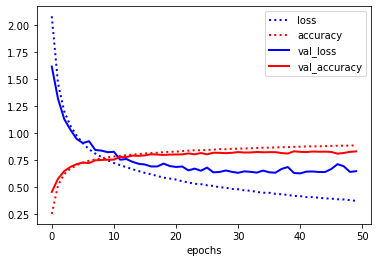

In [15]:
def build_model_1_1():
    model = models.Sequential()
#     model.add(layers.Flatten())
    model.add(layers.Reshape((3072,), input_shape=(32, 32, 3)))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.03))
    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU(alpha=0.03))
    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU(alpha=0.03))
    model.add(layers.Dense(32))
    model.add(layers.LeakyReLU(alpha=0.03))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer=custom_nadam, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

run_evaluation("model_1_1", build_model_1_1, evaluation_split, base_dir, 
               train=True, epochs=50, batch_size=64)
answer_q_1_1 = """
A higher number of layers would lead to overfitting and the validation 
accuracy remained low. Multiple optimizers were tested, N_Adam gave the best 
results. Leaky ReLu was picked to prevent the dying neurons problem and led 
to a ~5% increase in accuracy. Epochs and batch size were chosen by receiving
the best results in testing. A large batch size caused heavy fluctuations in loss.
"""
print("Answer is {} characters long".format(len(answer_q_1_1)))

### Question 1.2: Preprocessing (2 points)
Rerun the model, but now preprocess the data first by converting the images to 
greyscale. You can use the helper function below. If you want to do additional 
preprocessing, you can do that here, too.
* Store the preprocessed data as a tuple `preprocessed_split`
* Rerun and re-evaluate your model using the preprocessed data.
  * For the remainder of the assignment, always use the preprocessed data
* Explain what you did and interpret the results in 'answer_q_1_2'. Is the model
  better, if so, why?

In [16]:
# Luminance-preserving RGB to greyscale conversion
def rgb2gray(X):
    return np.expand_dims(np.dot(X, [0.2990, 0.5870, 0.1140]), axis=3)
  
# Replace with the preprocessed data
preprocessed_split = rgb2gray(X_train), rgb2gray(X_val), y_train, y_val

Training the model
Train on 63544 samples, validate on 15887 samples
Epoch 1/50
63544/63544 [==============================] - 7s 113us/sample - loss: 2.0467 - accuracy: 0.2700 - val_loss: 1.5734 - val_accuracy: 0.4610
Epoch 2/50
63544/63544 [==============================] - 6s 97us/sample - loss: 1.3789 - accuracy: 0.5422 - val_loss: 1.2196 - val_accuracy: 0.6108
Epoch 3/50
63544/63544 [==============================] - 6s 92us/sample - loss: 1.1285 - accuracy: 0.6481 - val_loss: 1.0649 - val_accuracy: 0.6736
Epoch 4/50
63544/63544 [==============================] - 6s 96us/sample - loss: 1.0010 - accuracy: 0.6931 - val_loss: 0.9780 - val_accuracy: 0.7021
Epoch 5/50
63544/63544 [==============================] - 6s 99us/sample - loss: 0.9170 - accuracy: 0.7191 - val_loss: 0.9625 - val_accuracy: 0.7076
Epoch 6/50
63544/63544 [==============================] - 6s 99us/sample - loss: 0.8612 - accuracy: 0.7373 - val_loss: 0.8601 - val_accuracy: 0.7413
Epoch 7/50
63544/63544 [============

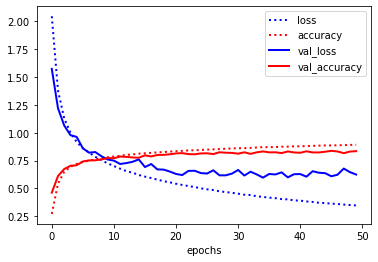

In [17]:
# Adjusted model
def build_model_1_2():
    model = models.Sequential()
#     model.add(layers.Flatten())
    model.add(layers.Reshape((1024,), input_shape=(32, 32, 1)))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.03))
    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU(alpha=0.03))
    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU(alpha=0.03))
    model.add(layers.Dense(32))
    model.add(layers.LeakyReLU(alpha=0.03))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer=custom_nadam,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    return model

# Evaluate. Use a new name 'model_1_2' to not overwrite the previous trained model
run_evaluation("model_1_2", build_model_1_2, preprocessed_split, base_dir, 
               train=True, epochs=50, batch_size=64)
answer_q_1_2 = """
Only applying grayscale on the input data and leads to an increase of ~1% 
to the validation accuracy. The loss remains stable and similar to model1_1.
We can conclude that the model does not pay much attention to the colour of the images.
"""
print("Answer is {} characters long".format(len(answer_q_1_2)))

### Question 1.3: Regularization and tuning (4 points)
* Regularize the model. You can explore (and combine) different techniques. What works best?
* Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
* Explain your findings and final design decisions. Retrain the model again on the preprocessed data and discuss the results.
* Return your model in function 'build_model_1_3' and write your answer in 'answer_q_1_3'

Training the model
Train on 63544 samples, validate on 15887 samples
Epoch 1/50
63544/63544 [==============================] - 13s 201us/sample - loss: 1.5575 - accuracy: 0.4779 - val_loss: 1.0694 - val_accuracy: 0.6687
Epoch 2/50
63544/63544 [==============================] - 10s 162us/sample - loss: 1.1708 - accuracy: 0.6285 - val_loss: 0.8779 - val_accuracy: 0.7288
Epoch 3/50
63544/63544 [==============================] - 10s 162us/sample - loss: 1.0449 - accuracy: 0.6730 - val_loss: 0.8186 - val_accuracy: 0.7492
Epoch 4/50
63544/63544 [==============================] - 11s 166us/sample - loss: 0.9648 - accuracy: 0.6970 - val_loss: 0.7323 - val_accuracy: 0.7767
Epoch 5/50
63544/63544 [==============================] - 10s 165us/sample - loss: 0.9090 - accuracy: 0.7155 - val_loss: 0.6950 - val_accuracy: 0.7864
Epoch 6/50
63544/63544 [==============================] - 11s 166us/sample - loss: 0.8709 - accuracy: 0.7268 - val_loss: 0.6542 - val_accuracy: 0.7992
Epoch 7/50
63544/63544 [=

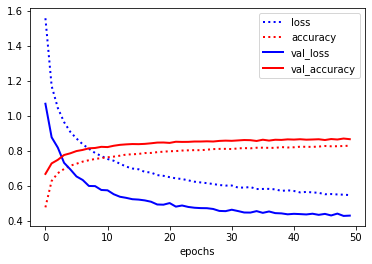

In [18]:
from tensorflow.keras.regularizers import l1, l2, l1_l2

def build_model_1_3():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32, 32, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.03))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU(alpha=0.03))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU(alpha=0.03))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(32))
    model.add(layers.LeakyReLU(alpha=0.03))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer=custom_nadam,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    return model


run_evaluation("model_1_3", build_model_1_3, preprocessed_split, base_dir, 
               train=True, epochs=50, batch_size=64)
answer_q_1_3 = """
The regularization methods tried out were l1,l2,batch normalization and dropout.
l1 gave terrible results, while l2 reached a maximum of 79% accuracy.
Best results obtained by combining the remaining methods between layers.
Low dropout rate of 0.1 fit the validation data well and leads to a ~3% accuracy increase.
"""
print("Answer is {} characters long".format(len(answer_q_1_3)))

## Part 2. Convolutional neural networks (10 points)
### Question 2.1: Design a ConvNet (7 points)
- Build a sequential convolutional neural network. Try to achieve the best validation accuracy you can. You should be able to get at least 90% accuracy. You can use any depth, any combination of layers, and any kind of regularization and tuning. 
- Add a description of your design choices in 'answer_q_2_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- You are allowed **800** characters for this answer (but don’t ramble).
- The name of the model should be 'model_2_1'. Evaluate it using the 'run_evaluation' function and the preprocessed data.

Training the model
Train on 63544 samples, validate on 15887 samples
Epoch 1/20
63544/63544 [==============================] - 62s 972us/sample - loss: 0.7753 - accuracy: 0.7533 - val_loss: 0.3558 - val_accuracy: 0.8912
Epoch 2/20
63544/63544 [==============================] - 56s 882us/sample - loss: 0.3626 - accuracy: 0.8923 - val_loss: 0.4512 - val_accuracy: 0.8613
Epoch 3/20
63544/63544 [==============================] - 56s 885us/sample - loss: 0.2962 - accuracy: 0.9139 - val_loss: 0.2984 - val_accuracy: 0.9117
Epoch 4/20
63544/63544 [==============================] - 56s 883us/sample - loss: 0.2563 - accuracy: 0.9254 - val_loss: 0.2517 - val_accuracy: 0.9269
Epoch 5/20
63544/63544 [==============================] - 57s 892us/sample - loss: 0.2273 - accuracy: 0.9344 - val_loss: 0.2450 - val_accuracy: 0.9300
Epoch 6/20
63544/63544 [==============================] - 57s 889us/sample - loss: 0.2077 - accuracy: 0.9401 - val_loss: 0.3900 - val_accuracy: 0.8806
Epoch 7/20
63544/63544 [=

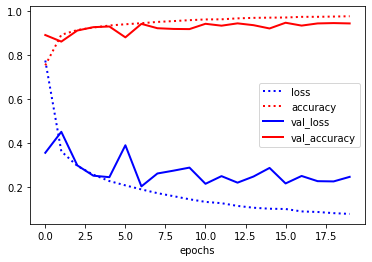

In [19]:
def build_model_2_1():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.03))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU(alpha=0.03))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='Nadam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

run_evaluation("model_2_1", build_model_2_1, preprocessed_split, base_dir, 
               train=True, epochs=20, batch_size=64)
answer_q_2_1 = """
Tried out 3 sets of 3 convolutional layers, but led to overfitting.
Leaky ReLu as activations on the convolutional layers did not work, so switched to relu.
Removing MaxPool after the first 2 Convolutional layers, slightly improved the results.
Adding an additional dense layer, made the model prone to overfitting.
There was no need to switch the optimizer, as results were satisfactory.
Larger epochs did not improve accuracy only computation time.
The highest accuracy reached was 95%, which is a significant improvement over the previous models.
"""
print("Answer is {} characters long".format(len(answer_q_2_1)))

### Question 2.2: Data Augmentation (3 points)

- Augment the preprocessed training data. You can explore using image shifts, rotations, zooming, flips, etc. What works well, and what does not?
- Evaluate the model from question 2.1 with the augmented data using the 'run_evaluation' function. Store the new trained model as 'model_2_2'.
- Add a description of your design choices in 'answer_q_2_2': explain what you did and also why. Also discuss the performance of the model.

Loading model from file
Success!
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_11 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_12 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_9 (Conv2D)    

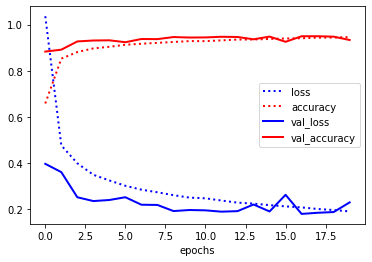

In [39]:
# Note that we build the same untrained model as in question 2.1 but store the 
# trained version as model_2_2. Change attributes as needed to run on augmented
# data
from tensorflow.keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(
	rotation_range=15,
	zoom_range=0.15,
	width_shift_range=0.05,
	height_shift_range=0.05,
	shear_range=0.15,
	fill_mode='nearest')
gen = datagen.flow(preprocessed_split[0], preprocessed_split[2], batch_size=64)
augmented_split = gen, preprocessed_split[1], preprocessed_split[3]
epoch_steps = int(X_train.shape[0] / 64)
run_evaluation("model_2_2", build_model_2_1, augmented_split, base_dir, 
               train=False, generator=True, epochs=20, batch_size=None, steps_per_epoch=epoch_steps)
answer_q_2_2 = """
Accuracy improvements are minimal, especially if the data is augmented with few methods.
Results are still good though, as we observe a steeper reduction in loss that remains steady.
Smaller rotation and zoom gave slightly better results.
Flipping the image, both vertically and horizontally, did not work, which was expected as numbers do not appear
overturned in the images.
Featurewise center did not perform well and plummeted accuracy to 81%.
"""
print("Answer is {} characters long".format(len(answer_q_2_2)))

## Part 3. Model interpretation (10 points)
### Question 3.1: Interpreting misclassifications (2 points)
Study which errors are still made by your last model (model_2_2) by evaluating it on the test data. You do not need to retrain the model.
* What is the accuracy of model_2_2 on the test data? Store this in 'test_accuracy_3_1'.
* Plot the confusion matrix in 'plot_confusion_matrix' and discuss which classes are often confused.
* Visualize the misclassifications in more depth by focusing on a single
class (e.g. the number '2') and analyse which kinds of mistakes are made for that class. For instance, are the errors related to the background, noisiness, etc.? Implement the visualization in 'plot_misclassifications'.
* Summarize your findings in 'answer_q_3_1'

In [ ]:
from sklearn.metrics import confusion_matrix

model = load_model_from_file(base_dir, "model_2_2")
test_accuracy_3_1 = 0.949707

y_pred = model.predict(X_test)
misclassified_samples = np.nonzero(np.argmax(y_test, axis=1) != np.argmax(y_pred, axis=1))[0]

def plot_confusion_matrix():
    labels = []
    for i in range(10):
        labels.append((i+1)%10)
    cm = confusion_matrix(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1))
    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm)
    ax.set_xticks(np.arange(10)), ax.set_yticks(np.arange(10))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')
    for i in range(100):
        ax.text(int(i/10),i%10,cm[i%10,int(i/10)], ha="center", va="center", color="w")

def plot_misclassifications():
    n = 0
    fig, axes = plt.subplots(1, 10,  figsize=(20, 10))
    for i in misclassified_samples:
        if (np.argmax(y_test[i])+1)%10 == 1:
            axes[n].imshow(X_test[i])
            axes[n].set_xlabel("Predicted: %s,\n Actual : %s" % ((np.argmax(y_pred[i])+1)%10, (np.argmax(y_test[i])+1)%10))
            axes[n].set_xticks(()), axes[n].set_yticks(())
            n = n + 1
            if n == 10:
                break
    plt.show()

plot_confusion_matrix()
plot_misclassifications()
answer_q_3_1 = """
The most misclassified number in the model is 1, followed by 2,3 and 5. 
The most confused pair is between 1 and 7, along with 3 and 5.
After plotting the misclassifications for multiple classes, we can distinguish three common reasons that lead to mistakes:
-Noise/Distortion in conjuction with the small size of the images.
-Multiple numbers appearing in the same image.
-Shadows that hide details of the numbers.
"""
print("Answer is {} characters long".format(len(answer_q_3_1)))

### Question 3.2: Visualizing activations (4 points)
* Implement a function `plot_activations()` that returns the most interesting activations (feature maps). Select the first example from the test set. Retrieve and visualize the activations of model 2_2 for that example (make sure you load that model in the function), for every filter for different convolutional layers (at different depths in the network).
* Give an explanation (as detailed as you can) about your observations in 'answer_q_3_2'. Is your model indeed learning something useful?

C:\Users\kitsa\Anaconda3\envs\tenso_gpu\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


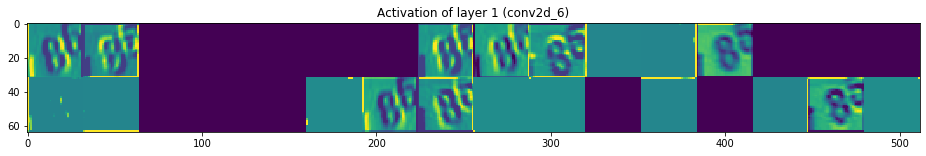

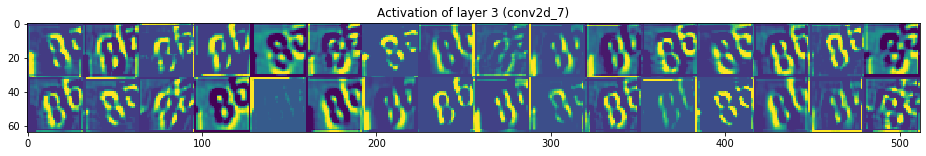

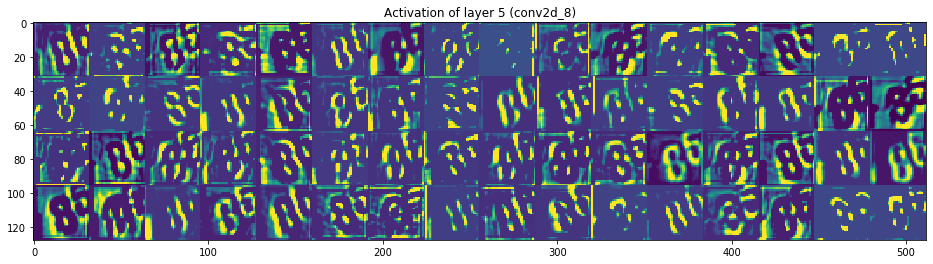

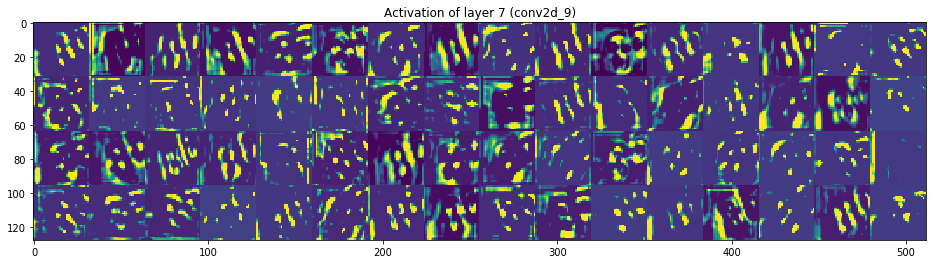

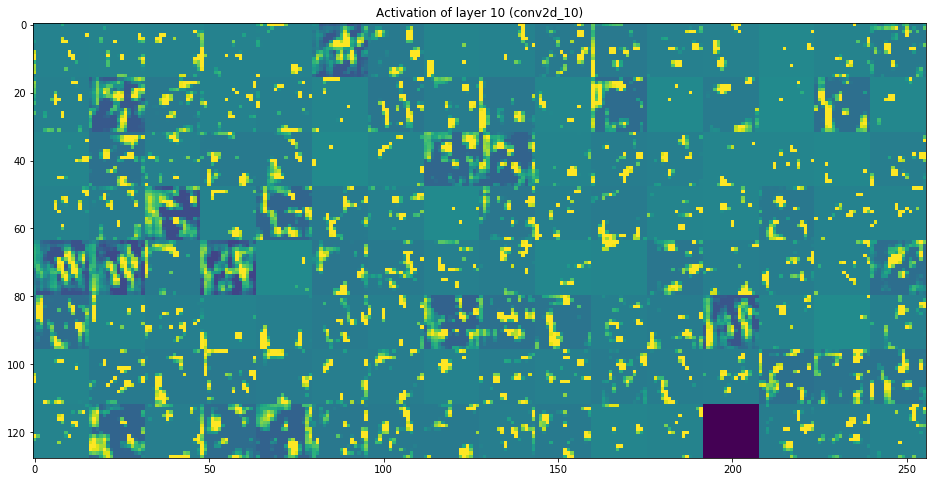

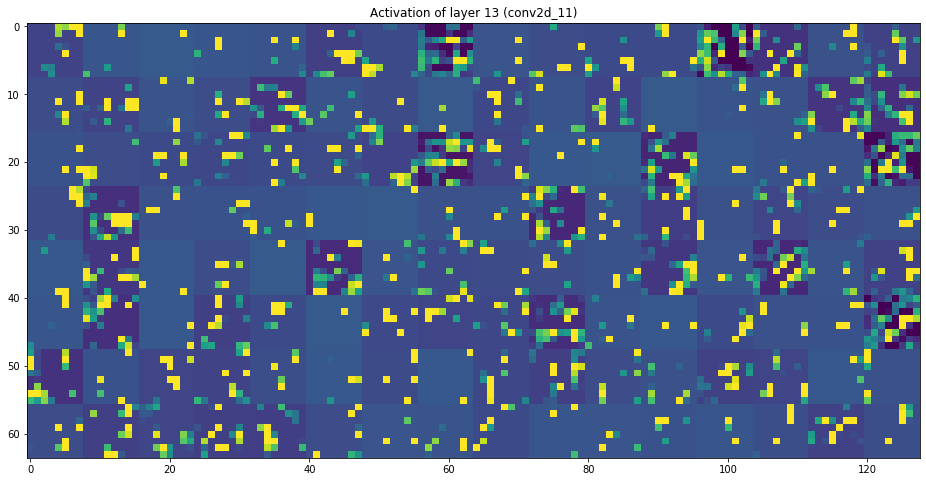

Answer is 490 characters long


In [22]:
# model.summary()
model = load_model_from_file(base_dir, "model_2_2")
img_tensor = np.expand_dims(X_test[0], axis=0)
last_conv2d_layer = 12
conv_layers = 13
layer_names = []
for layer in model.layers[:conv_layers]:
    layer_names.append(layer.name)
layer_outputs = [layer.output for layer in model.layers[:conv_layers]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)

def plot_activations():
    images_per_row = 16
    for i in range(conv_layers):
        name = layer_names[i]
        if name.startswith("conv2d"):
            layer_activation = activations[i]
            n_features = layer_activation.shape[-1]
            size = layer_activation.shape[1]
            n_cols = n_features // images_per_row
            display_grid = np.zeros((size * n_cols, images_per_row * size))
            for col in range(n_cols):
                for row in range(images_per_row):
                    channel_image = layer_activation[0, :, :, col * images_per_row + row]
                    channel_image -= channel_image.mean()
                    channel_image /= channel_image.std()
                    channel_image *= 64
                    channel_image += 128
                    channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                    display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
            scale = 1. / size
            plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
            plt.title("Activation of layer {} ({})".format(i+1,name))
            plt.grid(False)
            plt.imshow(display_grid, aspect='auto', cmap='viridis')
            plt.show()
  
plot_activations()

answer_q_3_2 = """
The used case is constructive, as the image contains two numbers and the model predicts right.
The first layer does not learn much, as about half of the filter activations are empty.
Layers 3 and 5 are extremely useful by highlighting the border of the number 8.
Layer 5 focuses on the correct number of the two.
Layer 7 appears to focus on the vertical lines of the image.
The last two layers are very abstract, so it is impossible to understand how they are used for classification.
"""
print("Answer is {} characters long".format(len(answer_q_3_2)))

### Question 3.3: Visualizing activations (4 points)
* Again, select the first example from the test set, and the trained model_2_2.
* Implement a function `plot_activation_map()` that builds and shows a class activation map for your last convolutional layer that highlights what the model is paying attention to when classifying the example.
* If possible, superimpossible the activation map over the image. If not, plot
them side by side. Implement a function 'plot_3_3' that returns the entire plot.

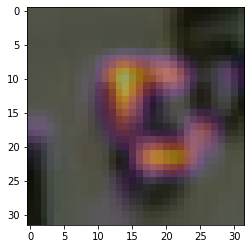

In [33]:
from tensorflow.keras import backend as K
import cv2
tf.compat.v1.disable_eager_execution()

def plot_activation_map():
    model = load_model_from_file(base_dir, "model_2_2")
    img_tensor = np.expand_dims(X_test[0], axis=0)
    img_prediction = model.predict(img_tensor)
    last_output = model.get_layer("conv2d_11").output
    eight_output = model.output[:,np.argmax(img_prediction[0])]
    grads = K.gradients(eight_output, last_output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([img_tensor])
    for i in range(128):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    act_map = np.mean(conv_layer_output_value, axis=-1)
    act_map = np.maximum(act_map, 0)
    act_map /= np.max(act_map)
    return act_map


def plot_3_3():  
    act_map = plot_activation_map()
    act_map = cv2.resize(act_map, (32, 32))
    im1 = plt.imshow(img_tensor[0])
    im2 = plt.imshow(act_map, alpha=0.5, cmap=plt.cm.inferno)
    plt.show()
  
plot_3_3()

## Part 4. Transfer learning (10 points)
### Question 4.1 Fast feature extraction with VGG16 (5 points)
- Import the VGG16 model, pretrained on ImageNet. [See here](https://keras.io/applications/). Only import the convolutional part, not the dense layers.
- Implement a function 'build_model_4_1` that adds a dense layer to the convolutional base, and freezes the convolutional base. Consider unfreezing the last few convolutional layers and evaluate whether that works better.
- Train the resulting model on the *original* (colored) training data
- Evaluate the resulting model using 'run_evaluate'. Discuss the observed performance in 'answer_q_4_1'.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Training the model
Train on 63544 samples, validate on 15887 samples
Epoch 1/20
63544/63544 [==============================] - 118s 2ms/sample - loss: 0.7586 - accuracy: 0.7593 - val_loss: 0.5662 - val_accuracy: 0.8275
Epoch 2/20
63544/63544 [==============================] - 115s 2ms/sample - loss: 0.4101 - accuracy: 0.8747 - val_loss: 0.4063 - val_accuracy: 0.8759
Epoch 3/20
63544/63544 [==============================] - 115s 2ms/sample - loss: 0.3318 - accuracy: 0.9022 - val_loss: 0.3927 - val_accuracy: 0.8878
Epoch 4/20
63544/63544 [==============================] - 115s 2ms/sample - loss: 0.2827 - accuracy: 0.9168 - val_loss: 0.2996 - val_accuracy: 0.9101
Epoch 5/20
63544/63544 [==============================] - 115s 2ms/sample - loss: 0.2513 - accuracy: 0.9264 - val_loss: 0.3091 - val_accuracy: 0.9072
Epoch 6/20
63544/63544 [==============================] - 115s 2ms/sample - loss: 0.2252 - accuracy:

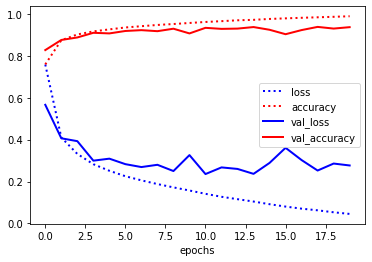

In [24]:
from tensorflow.keras.applications import VGG16

def build_model_4_1():
    model = models.Sequential()
    conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU(alpha=0.03))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))
    conv_base.trainable = True
    for layer in conv_base.layers:
        if layer.name.startswith('block5') or layer.name.startswith('block4') or layer.name.startswith('block3'):
            layer.trainable = True
        else:
            layer.trainable = False
# 3-5 freeze    0.933719
# 4-5 freeze    0.903632
# 5 freeze     0.824574
# no freeze 0.939321
    model.compile(optimizer=optimizers.SGD(lr=3e-3),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    return model

run_evaluation("model_4_1", build_model_4_1, evaluation_split, base_dir, 
               train=True, epochs=20, batch_size=64)
answer_q_4_1 = """
The optimizer was changed to sgd to satisfy the memory
constraint while providing good results. The learning rate had to be tuned
for each model to provide optimal results. Tests were conducted with unfreezing
a different number of the outer layers. It would be more appropriate to
train the convolutional base on our dataset to provide accurate embeddings
in 4_2, so I opted to unfreeze layers 3,4,5."""
print("Answer is {} characters long".format(len(answer_q_4_1)))

### Question 4.2 Embeddings and pipelines (5 points)
- Generate embeddings of the original images by running them through the trained convolutional part of model_4_1 (without the dense layer) and returning the output. Embed the training and test data and store them to disk using the helper functions below. Implement a function `store_embeddings` that loads model_4_1 and stores all necessary embeddings to file. Make sure to run it once so that the embeddings are stored (and submitted).
- Implement a function 'generate_pipeline' that returns an scikit-learn pipeline. You can use any non-deep learning technique (eg. SVMs, RFs,...), and preprocessing technique. You can do model selection using the validation set. 
- Implement a function 'evaluate_pipeline' that evaluates a given pipeline on a given training and test set. 
- Implement a function 'evaluation_4_2' that evaluates your pipeline on the embedded training and test set (loaded from file) and returns the accuracy. 
- Describe what you did and what you observed. Report the obtained accuracy score. Can you beat your best model thus far?

In [26]:
import pickle
import gzip
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from tensorflow.keras.applications import VGG16


emb_dir = './embeddings/'
stop_training = True

def store_embedding(X, name):  
    with gzip.open(os.path.join(emb_dir, name+'_embedding.p'), 'wb') as file_pi:
        pickle.dump(X, file_pi)

def load_embedding(name):
    with gzip.open(os.path.join(emb_dir, name+'_embedding.p'), 'rb') as file_pi:
        return pickle.load(file_pi)

def store_embeddings():
#   Stores all necessary embeddings to file
    conv_base = load_model_from_file('./models/', "model_4_1").layers[0]
    X_train_all_predictions = conv_base.predict(X_train_all)
    store_embedding(X_train_all_predictions, "all_train")
    X_test_predictions = conv_base.predict(X_test)
    store_embedding(X_test_predictions, "all_test")
    X_train_predictions = conv_base.predict(X_train)
    store_embedding(X_train_predictions, "X_train")
    X_val_predictions = conv_base.predict(X_val)
    store_embedding(X_val_predictions, "X_val")
    
def transform(X):
    return np.reshape(X, (len(X), -1))

def generate_pipeline():
#   Returns an sklearn pipeline.
    clf = SVC()
    scaler = PCA()
    pipeline = Pipeline(steps=[
        ('transformer', FunctionTransformer(transform)),
        ('scaler', scaler),
        ('classifier', clf)])
    return pipeline


def evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test):
#    Evaluates the given pipeline, trained on the given embedded training set and 
#    evaluated on the supplied embedded test set. Returns the accuracy score.
    pipeline.fit(X_train, y_train)
    score = pipeline.score(X_test, y_test)
    return score
#     0.9416859703897673 SVC
#     0.9382113002316447 RandomForestClassifier()
#     classification_report(y_test, pipeline.predict(X_test))


def evaluation_4_2(X_train, y_train, X_test, y_test):
#   Runs 'evaluate_pipeline' with embedded versions of the input data 
#   and returns the accuracy.

# For some reason load_embedding produced an error on verify.py
#     train_emb = load_embedding(X_train)
#     test_emb = load_embedding(X_test)

    base_model = load_model_from_file('./models/', "model_4_1").layers[0]
    train_emb = base_model.predict(X_train)
    test_emb = base_model.predict(X_test)
    y_train_emb = np.argmax(y_train, axis=1)
    y_test_emb = np.argmax(y_test, axis=1)
    pipe = generate_pipeline()
    final_score = evaluate_pipeline(pipe, train_emb, y_train_emb, test_emb, y_test_emb)
    return final_score
    

# store_embeddings()
# evaluation_4_2("all_train", y_train_all, "all_test", y_test)
evaluation_4_2(X_train_all, y_train_all, X_test, y_test)
print("Pipeline:",generate_pipeline())
answer_q_4_2 = """
The tried out techniques were logistic regression, SVM and RF.
The obtained score was quite satisfactory reaching 0.9417, which is slightly
worse than the one from the convolutional NN.
Using SVM instead of RF leads to a 0.5 improvement, but in a fraction of the time. 
PCA was applied in an attempt to reduce the evaluation time.
"""
print("Answer is {} characters long".format(len(answer_q_4_2)))

0.9416859703897673
Pipeline: Pipeline(memory=None,
         steps=[('transformer',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function transform at 0x0000029334BAD558>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, validate=False)),
                ('scaler',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('classifier',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)
Answer 